## Evaluation

In [1]:
#get latest weight file
%cd EfficientDet_ckpt/EfficientDet_d0
weight_file = !ls -Art | grep efficientdet
%cd ../..

!python coco_eval.py -c 0 -p 'EfficientDet_d0' -w 'EfficientDet_ckpt/EfficientDet_d0/{weight_file[-1]}'

/home/minki_kwak01/minki/EfficientDet/Yet-Another-EfficientDet-Pytorch/EfficientDet_ckpt/EfficientDet_d0
/home/minki_kwak01/minki/EfficientDet/Yet-Another-EfficientDet-Pytorch
running coco-style evaluation on project EfficientDet_d0, weights EfficientDet_ckpt/EfficientDet_d0/efficientdet-d0_99_200000.pth...
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
100%|███████████████████████████████████████| 2000/2000 [02:22<00:00, 14.05it/s]
Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.79s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 

## Visualize

In [2]:
import os

test_img = os.listdir('test_data/images')

test_img

['1656986511059_FR-View-CMR-Wide.png',
 '1654757828026_FR-View-CMR-Wide.png',
 '1656979458907_FR-View-CMR-Wide.png',
 '1660641612345_FR-View-CMR-Wide.png',
 '1657619171712_FR-View-CMR-Wide.png',
 '1657618764186_FR-View-CMR-Wide.png',
 '1654756315023_FR-View-CMR-Wide.png',
 '1657618763553_FR-View-CMR-Wide.png',
 '1659931783137_FR-View-CMR-Wide.png',
 '1660641830385_FR-View-CMR-Wide.png',
 '1660641827586_FR-View-CMR-Wide.png',
 '1656148349883_FR-View-CMR-Wide.png',
 '1660292781255_FR-View-CMR-Wide.png',
 '1660641615377_FR-View-CMR-Wide.png',
 '1656979891917_FR-View-CMR-Wide.png',
 '1656045628561_FR-View-CMR-Wide.png',
 '1660620331595_FR-View-CMR-Wide.png',
 '1660291515659_FR-View-CMR-Wide.png',
 '1659415249147_FR-View-CMR-Wide.png',
 '1660641823987_FR-View-CMR-Wide.png',
 '1657618764286_FR-View-CMR-Wide.png',
 '1659931782105_FR-View-CMR-Wide.png',
 '1660620180392_FR-View-CMR-Wide.png',
 '1660641829485_FR-View-CMR-Wide.png',
 '1659413162700_FR-View-CMR-Wide.png',
 '1660291131188_FR-View-C

/tmp/ipykernel_1478/4097867693.py:79: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)


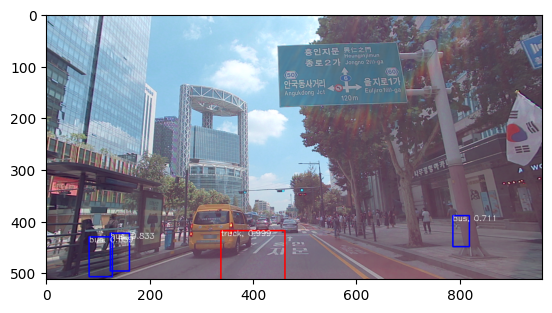

In [7]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

compound_coef = 0
force_input_size = None  # set None to use default size
img_path = 'test_data/images/1660620331595_FR-View-CMR-Wide.png'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['car', 'truck', 'bus', 'pedestrian']

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(0.7, 1.4), (1.0, 1.0), (1.5, 0.7)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('EfficientDet_ckpt/EfficientDet_d0/'+weight_file[-1]))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

green_color=(0, 255, 0)
red_color=(255, 0, 0)
blue_color=(0, 0, 255)
pink_color=(255, 0, 255)
white_color=(255, 255, 255)
line_color=(0, 0, 0)

out = invert_affine(framed_metas, out)
# plt.figure(figsize=(15,13))
for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    ori_imgs[i] = cv2.cvtColor(ori_imgs[i], cv2.COLOR_BGR2RGB)
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        if obj == 'car':
            line_color = green_color
        elif obj == 'truck':
            line_color = red_color
        elif obj == 'bus':
            line_color = blue_color
        else:
            line_color = pink_color

        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), line_color, 2)
        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    white_color, 1)

#         plt.axis('off')
        plt.imshow(ori_imgs[i])